# <center>Forecasting Auto Loan Performance: Buy Here, Pay Here Car Dealership

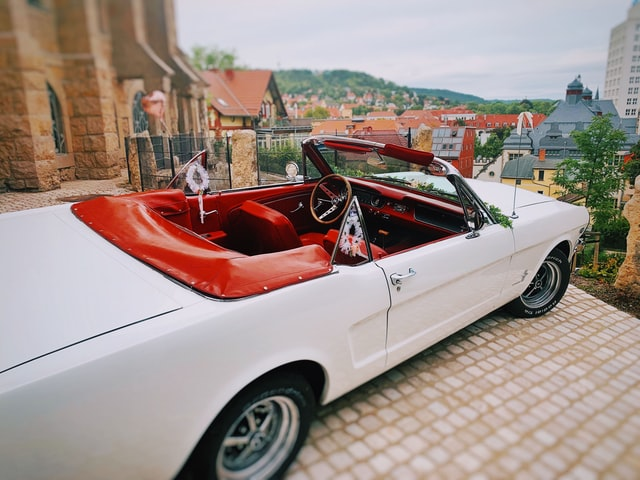
Photo by Jason Wu on [unsplash.com](https://unsplash.com/photos/xFfPXDWCceo)

Business forecasting is a competency that can make or break a firm. Forecasting future sales, profit margins, and cash flows is a key to sustainable operations. Cash flows management can significantly affect the financial performance of buy here, pay here car (BHPH) dealerships. BHPH dealerships typically extend credit to auto buyers who cannot meet credit standards elsewhere. Usually, these buyers have substandard or no credit history. As such, loans tend to have high-interest rates and increased default risks. A cash crunch can cause firms to go out of business. To assess the dealership's future financial health, it is crucial to forecast how well it will collect loan payments from car buyers.

This notebook describes a prototype of a production-ready forecasting model for a leading lending firm with the exciting mission to provide funds and loan management to BHPH dealerships. The model predicts the rate of return on car loans extended by a BHPH dealership of used cars in the southeastern US. The resulting model confidently forecasts that the dealership will have higher than its typical performance during at least the next four quarters: 2022Q2-2023Q1.

# Initial Data Exploration and Observations
The dataset contains 4,104 instances of sold cars between February 11, 2008 and March 22, 2022. The dealership has been selling used cars with a typical age of about nine years and an average price of $14,649. The dealership sold 273 cars in a typical year, with about 78 percent of those financed by the dealership. 

Typically, loans were issued for about three years with an average APR of 28 and a down payment of $1,640. However, payments on loans were made for about a year on average. That is, car buyers did not make payments for the remaining two years. However, the dealership recovered losses on many defaulted loans by repossessing and reselling loaned cars. The percentage of cars in the dataset that were later resold at least once was 40.

Because my focus is to forecast the rate of return on loans issued by the dealership, I use a subset of the dataset that included only 'BS' and 'BP' values for the typedeal column. The heat map shows that the dataset does not have many missing values, except for the nextpaymentdate column and, to some extent, the lastpaymentdate column. I dropped the nextpaymentdate column because it has too many missing values. To address missing values in the lastpaymentdate column, I dropped the rows with missing cases and kept the column. I also used the lastpaymentdate column as the dataframe's index.

In [1]:
#import Python libraries
import pandas as pd 
pd.set_option('display.max_rows', None, 'display.max_columns', None, 'display.width', None)
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
import seaborn as sns
sns.set(rc={'figure.figsize':(17, 4)})
import numpy as np
import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
from math import sqrt
from sklearn.metrics import mean_squared_error

C:\Users\Misha\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
#read in the dataset into dataframe and subset it by BS and BP deal types
df = pd.read_csv('data.csv', parse_dates=['Year','SaleDate','FirstPayDueDate', 'NextPaymentDate', 'LastPaymentDate'])
df.columns = df.columns.str.lower()
df = df[(df.typedeal == 'BS') | (df.typedeal == 'BP')]
df.sample(3)

,accountno,year,make,model,vin,odometer,saledate,typedeal,apr,currentbalance,amttofinance,firstpayduedate,paymentamount,lastpayamount,down,nextpaymentdate,lastpaymentdate,numberofpayments,paymentterms,paymentperiod,numbertradins,openbalance,totalsaleprice,totalofpayments,tradein,tradeacv,tradepayoff,financecharge,princollected,intcollected,saleno,address,city,state,zip
1614,14083,2006-01-01,BMW,3-Series,WBAVB13596KX64131,133944,2016-03-03,BP,29.8,0.00,10921.66,2016-03-15,202.86,0.0,0.0,NaT,2016-04-29,84,84 BI-WEEKLY,BI-WEEKLY,1,17040.24,19039.58,17040.24,11725.0,5500,9725.66,6118.58,246.57,567.12,1312,40 ADELAIDE DR.,Covington,GA,30016-
1295,11913,2004-01-01,BMW,X3 4D SAV 2.5I,WBXPA73444WB26597,108308,2014-06-03,BP,16.9,9874.58,11474.06,2014-06-19,188.17,0.0,2800.0,2014-08-14,2014-12-31,78,78 BI-WEEKLY,BI-WEEKLY,0,14677.26,17477.26,14677.26,0.0,0,0.00,3203.20,434.56,318.12,904,4020 VERACRUZ DRIVE,DECATUR,GA,30034
3956,17008,2011-01-01,Volkswagen,Jetta,3VWDX7AJ8BM360563,0,2021-09-24,BS,29.8,9326.50,10913.15,2021-10-08,219.55,0.0,1400.0,2022-04-08,2022-03-18,74,74 BI-WEEKLY,BI-WEEKLY,0,11413.15,18146.70,16746.70,0.0,0,0.00,5333.55,1586.65,1503.79,5280,2210 SULLIVAN RD.,COLLEGE PARK,GA,30337-


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3212 entries, 0 to 4103
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   accountno         3207 non-null   object        
 1   year              3212 non-null   datetime64[ns]
 2   make              3212 non-null   object        
 3   model             3212 non-null   object        
 4   vin               3212 non-null   object        
 5   odometer          3212 non-null   int64         
 6   saledate          3212 non-null   datetime64[ns]
 7   typedeal          3212 non-null   object        
 8   apr               3212 non-null   float64       
 9   currentbalance    3212 non-null   float64       
 10  amttofinance      3212 non-null   float64       
 11  firstpayduedate   3212 non-null   datetime64[ns]
 12  paymentamount     3212 non-null   float64       
 13  lastpayamount     3212 non-null   float64       
 14  down              3212 n

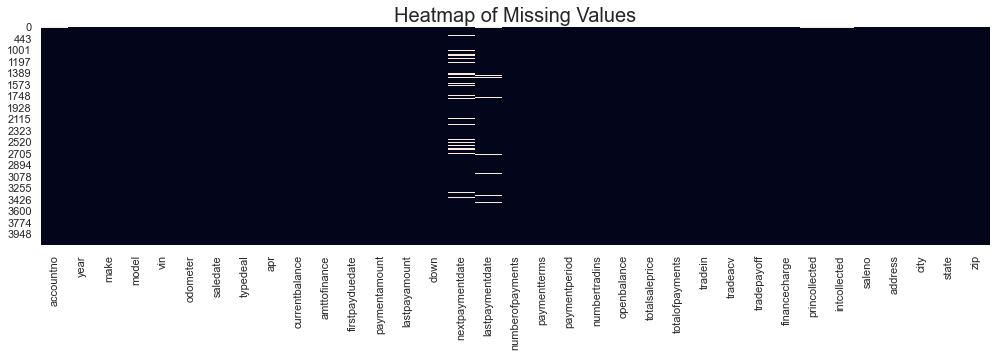

In [4]:
# create heatmap for missing values
sns.heatmap(df.isnull(), cbar=False)
plt.title('Heatmap of Missing Values', fontsize=20)
plt.show()

In [5]:
#drop missing values and set lastpaymentdate as index
df.dropna(subset='lastpaymentdate', inplace=True)
df.drop('nextpaymentdate', axis=1, inplace=True)
df = df.set_index('lastpaymentdate')
df.sort_index(inplace=True)

# Feature Engineering
To calculate the rate of return, I created a collections column (sum of princollected and intcollected columns) and divided it by the totalofpayments column. To convert the resulting column to a percentage form, I multiplied it by 100. Then, I created a lastpay_year column, which indicates the year when the last payment on a given loan was made.

Using these new columns, I created a bar plot to depict the average rate of return per sold car across years. The plot reveals that the rate of return was relatively low in 2010 and 2011, then picked up between 2012 and 2015 and stabilized starting in 2016. The rate of return averaged 30% across years.

To determine the contractual duration of loans, I created a loan_length column using values in the paymentperiod and numberofpayments columns. I used values of the vin column to identify cars that were resold. The dataset indicates that 40 percent of cars were resold again at least once. By taking into account the proceeds from resales, the cumulative rate of return per car sold was 45%.

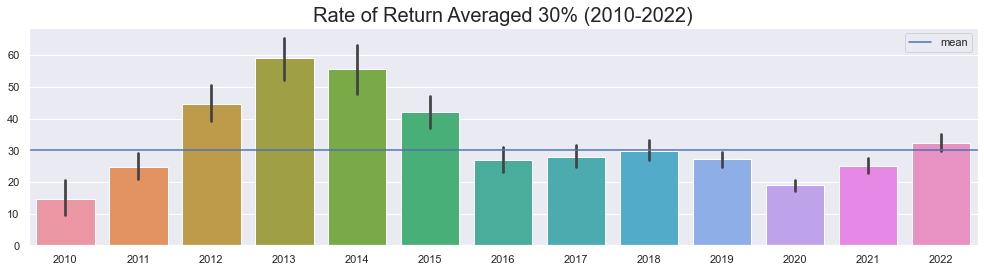

In [6]:
#create new features
df['collections'] = df.princollected + df.intcollected 
df['return_rate'] = df.collections/ df.totalofpayments * 100
df['lastpay_year'] = df.index.year

#create bar plot
sns.barplot(x='lastpay_year', y='return_rate', data=df) 
plt.title('Rate of Return Averaged 30% (2010-2022)', fontsize=20)
plt.axhline(df.return_rate.mean(), label='mean')
plt.ylabel('')
plt.xlabel('')
plt.legend()
plt.show()

In [7]:
#calculate length of loan contract in days
def dur(string):
    if string == 'BI-WEEKLY':
        return 14
    elif string == 'SEMI-MONTHLY':
        return 15
    elif string == 'MONTHLY':
        return 30
    elif string == 'WEEKLY':
        return 7    
df['loan_length'] = df.paymentperiod.apply(dur)*df.numberofpayments
print("Average annual loan lenght: {:.0f}".format(df.loan_length.mean()/365))

Average annual loan lenght: 3


In [8]:
#calculate percentage of cars that re-sold at least once
print("Percentage of cars that were re-sold at least once: {:.0f}".format((1-df.vin.nunique()/len(df))*100))

Percentage of cars that were re-sold at least once: 40


In [9]:
#calculate cumulative rate of return 
pivot = df.pivot_table(values = ['collections','totalsaleprice'], index='vin', aggfunc=[np.mean, np.sum])
pivot['cum_return_rate'] = pivot[( 'sum',    'collections')] / pivot[('mean', 'totalsaleprice')] *100
print("Cumulative rate of return per car: {:.0f}".format(pivot.cum_return_rate.mean()))

Cumulative rate of return per car: 45


# Forecasting
Quarterly frequency is more meaningful and aligns better with typical business planning than daily frequency. As such, I transformed daily sale transactions to quarterly frequency and used the transformed time series to forecast the future rate of return. I used the Autoregressive Integrated Moving Average (ARIMA) model, one of the go-to time series tools. I followed the Box-Jenkins method, a best-practices framework for using the ARIMA model to go from raw data to a model ready for production. The approach has three main steps: identification, estimation, and model diagnostics.

In [10]:
# Create time series with quarterly frequency
qrt = df.return_rate.resample('Q').mean()

## Identification
To model time series, it must be stationary. Stationary means that the distribution of the data doesn't change with time. For a times series to be stationary, it must fulfill three criteria: the series has zero trends, the variance is constant, and the autocorrelation is constant. There are two ways to examine if the data is stationary: visual assessment and the augmented Dicky-Fuller test. This is a statistical test with the null hypothesis that your time series is non-stationary due to trends.

The first plot shows that the series appears non-stationary. Thus, we need to transform the data into a stationary form before modeling it. I take the series difference to make it stationary by subtracting the previous value from each value in the time series. The second plot indicates that the transformed time series appears stationary. The test statistic of - 7.77 and p-value of smaller than 0.05 confirm that the data is stationary and can be used to make forecasts with the ARIMA model.

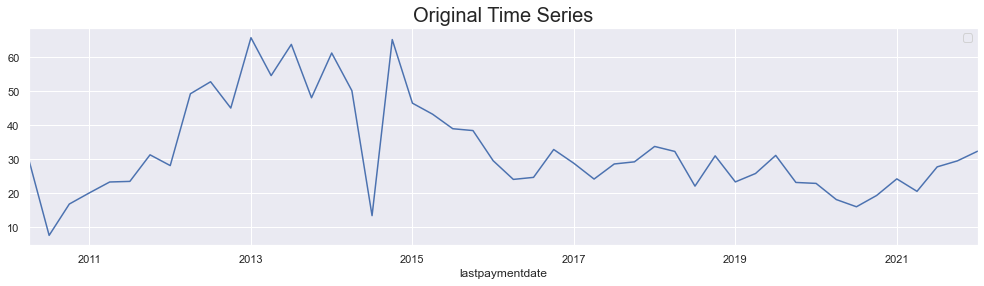

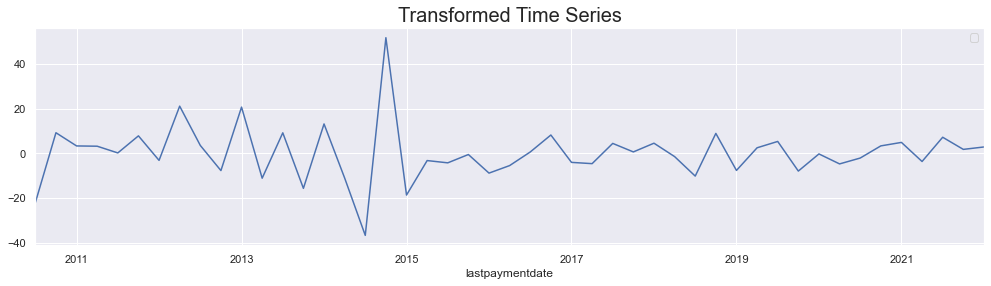

In [11]:
#Plot original time series
qrt.plot().legend('')
plt.title('Original Time Series',fontsize=20)
plt.show()

#Plot transformed time series
qrt.diff(1).dropna().plot().legend('')
plt.title('Transformed Time Series',fontsize=20)
plt.show()

In [12]:
# Augmented Dicky-Fuller test
adf = adfuller(qrt.diff(1).dropna())
print('ADF Statistic:', round(adf[0],2))
print('p-value:', adf[1])

ADF Statistic: -7.77
p-value: 8.972545875574345e-12


## Estimation: Hyperparameter Tuning
Akaike information criterion (AIC) and Bayesian information criterion (BIC) are metrics that tell us how good a model is. A model which makes better predictions is given lower AIC and BIC scores. AIC and BIC penalize complex models with higher order. AIC is better at choosing predictive models, while BIC is better at choosing a good explanatory model.

To find the best model order, I wrote loops to fit multiple ARIMA models to the time series. I looped over AR and MA orders between zero and two and fit each model. Then, I printed models along with the AIC and BIC scores. Results indicate that the model with the lowest AIC and BIC scores has zero autoregressive lags and two moving average lags.

In [13]:
#Searching over AIC and BIC
order_aic_bic =[]
# Loop over AR order
for p in range(3):
    # Loop over MA order
    for q in range(3):
        # Fit model
        model = SARIMAX(qrt, order=(p,1,q))
        results = model.fit()
        # Add order and scores to list
        order_aic_bic.append((p, q, results.aic, results.bic))

# Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order_aic_bic, columns=['p','q', 'aic', 'bic'])

# Sort by AIC
print(order_df.sort_values('aic'))

   p  q         aic         bic
2  0  2  358.820944  364.371387
6  2  0  359.143355  364.693797
5  1  2  360.579028  367.979618
1  0  1  360.627000  364.327295
4  1  1  360.742138  366.292581
7  2  1  360.913988  368.314579
3  1  0  361.427987  365.128282
8  2  2  361.956577  371.207315
0  0  0  373.783665  375.633812


## Model Diagnostics
The next step is using standard model diagnostics to confirm that the model is behaving well. To diagnose the model, I focus on the residuals of the training data. The residuals are the difference between the model's one-step-ahead predictions and the actual values of the time series. The residuals should be uncorrelated white Gaussian noise centered on zero for an ideal model. The generated four standard plots seem to indicate that this is so.

I used previous series values to estimate the next ones to examine in-sample predictions. This allows to evaluate how good the model is. The line plot shows the best estimate prediction marked with the red line, while the uncertainty range is shaded—the uncertainty due to random shock terms that the model cannot predict. The plot shows that the predicted values catch up to the observed values. Thus, predictions seem to align with the ground truth very well. Root Mean Squared Error (RMSE) is also reasonably low. RMSE indicates that the average distance between the predicted values of the return rate from the model and the actual values in the dataset is five.

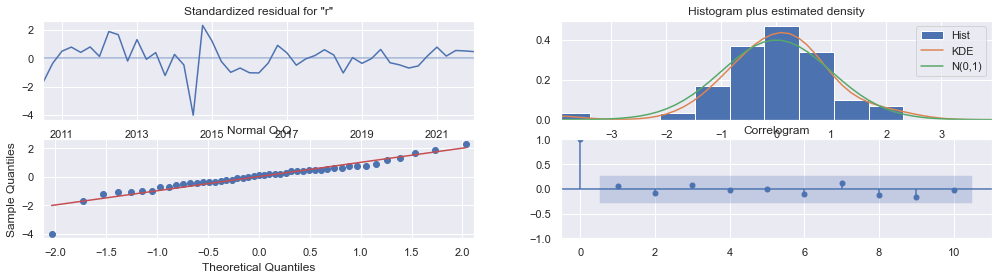

In [14]:
# Create ARIMA model
model = SARIMAX(qrt, order=(0,1,2))

# Fit ARIMA model
results = model.fit()

# Assign residuals to variable
residuals = results.resid

# Create the 4 diagostics plots
results.plot_diagnostics()
plt.show()

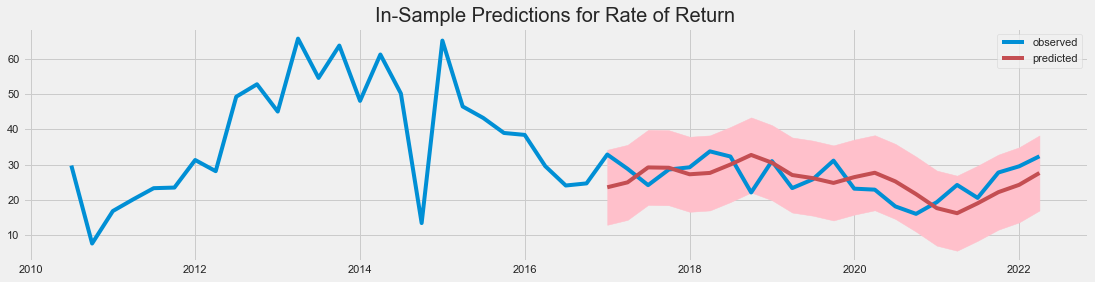

In [15]:
# Generate in-sample predictions
forecast = results.get_prediction(start= pd.to_datetime('2016-12-31'))

# Extract prediction mean
mean_forecast = forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = forecast.conf_int(alpha=0.30)

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower return_rate']
upper_limits = confidence_intervals.loc[:,'upper return_rate']

# plot the amazon data
style.use('fivethirtyeight')
plt.plot(qrt, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='predicted')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, title, legends and show plot
plt.xlabel('')
plt.ylabel('')
plt.title('In-Sample Predictions for Rate of Return',fontsize=20)
plt.legend()
plt.show()

In [16]:
#Calculating RMSE
train_forecasted = forecast.predicted_mean
train_truth = qrt['2016-12-31':]
rms_arima = sqrt(mean_squared_error(train_truth, train_forecasted))
print("Root Mean Squared Error: ", round(rms_arima))

Root Mean Squared Error:  5


# Production and Conclusion
Information gathered from statistical tests and plots during the diagnostic step indicates that the current model is good enough. As such, we can go ahead and make forecasts. The get_forecast function accepts a single argument indicating how many forecasting steps are desired. I included four as the number of quarters ahead to forecast. Alternatively, we can specify the date through which forecasts should be produced.

The line plot shows the best estimate prediction marked with the red line, while the uncertainty range is shaded. The plot and the table below indicate that the rate of return in the second quarter of 2022 is likely to be about 31%. The rate of return for the three following quarters is likely to be about 32%. The further into the future the forecast is, the higher the uncertainty range.

The historical rate of return averaged 30%. Thus, I confidently expect the dealership to have higher than its typical performance during at least the next four quarters: 2022Q2-2023Q1.

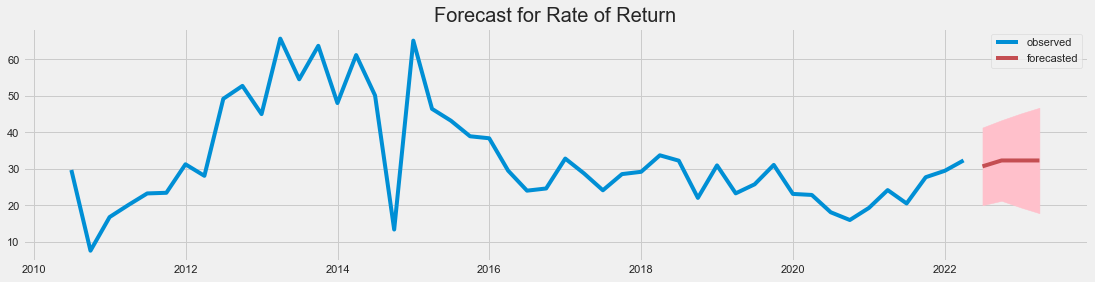

return_rate       mean    mean_se  mean_ci_lower  mean_ci_upper
2022Q2       30.723275  10.259674      20.089807      41.356744
2022Q3       32.333503  10.650906      21.294548      43.372457
2022Q4       32.333503  12.402883      19.478741      45.188264
2023Q1       32.333503  13.936327      17.889428      46.777577


In [17]:
# Generate forecast
forecast = results.get_forecast(steps=4)

# Extract prediction mean
mean_forecast = forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = forecast.conf_int(alpha=0.30)

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower return_rate']
upper_limits = confidence_intervals.loc[:,'upper return_rate']

# plot the amazon data
style.use('fivethirtyeight')
plt.plot(qrt, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecasted')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, title legends and show plot
plt.xlabel('')
plt.ylabel('')
plt.title('Forecast for Rate of Return',fontsize=20)
plt.legend()
plt.show()

# print forecasted values
forecast = results.get_forecast(steps=4)
frc = forecast.summary_frame(alpha=0.3)
frc.index = pd.PeriodIndex(frc.index, freq='Q')
print(frc)